In [ ]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')
# Load both datasets
df1 = pd.read_csv("/content/drive/MyDrive/FYP/Suicide_Detection.csv")
df2 = pd.read_csv("/content/drive/MyDrive/FYP/suicide_only_clean.csv")

print("===== DATASET 1: Suicide_Detection.csv =====")
print("Shape:", df1.shape)
print("Columns:", df1.columns.tolist())
print(df1.head(), "\n\n")

print("===== DATASET 2: suicide_only_clean.csv =====")
print("Shape:", df2.shape)
print("Columns:", df2.columns.tolist())
print(df2.head())


Mounted at /content/drive
===== DATASET 1: Suicide_Detection.csv =====
Shape: (232074, 3)
Columns: ['Unnamed: 0', 'text', 'class']
   Unnamed: 0                                               text        class
0           2  Ex Wife Threatening SuicideRecently I left my ...      suicide
1           3  Am I weird I don't get affected by compliments...  non-suicide
2           4  Finally 2020 is almost over... So I can never ...  non-suicide
3           8          i need helpjust help me im crying so hard      suicide
4           9  I’m so lostHello, my name is Adam (16) and I’v...      suicide 


===== DATASET 2: suicide_only_clean.csv =====
Shape: (9992, 3)
Columns: ['text', 'label', 'clean_text']
                                                text         label  \
0  I am so exhausted of this. Just when I think I...  SuicideWatch   
1  I am 20 year old with some good friends but I ...  SuicideWatch   
2  it is looming around the corner again. It alwa...  SuicideWatch   
3  there is...

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from google.colab import drive

drive.mount('/content/drive')

nltk.download('vader_lexicon')

df1 = pd.read_csv("/content/drive/MyDrive/FYP/Suicide_Detection.csv")
df2 = pd.read_csv("/content/drive/MyDrive/FYP/suicide_only_clean.csv")

df1 = df1[['text', 'class']]
df1['label'] = df1['class'].map({'suicide': 1, 'non-suicide': 0})
df1.drop(columns=['class'], inplace=True)

df2 = df2[['clean_text', 'label']]
df2.rename(columns={'clean_text': 'text'}, inplace=True)
df2['label'] = 1    # Because SuicideWatch = suicide posts

df = pd.concat([df1, df2], ignore_index=True)

print("Final merged shape:", df.shape)
print(df['label'].value_counts())
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Final merged shape: (242066, 2)
label
1    126029
0    116037
Name: count, dtype: int64


,text,label
0,Ex Wife Threatening SuicideRecently I left my ...,1
1,Am I weird I don't get affected by compliments...,0
2,Finally 2020 is almost over... So I can never ...,0
3,i need helpjust help me im crying so hard,1
4,"I’m so lostHello, my name is Adam (16) and I’v...",1


In [ ]:
#feature extraction
sia = SentimentIntensityAnalyzer()

keywords = [
    "suicide","kill","die","end","worthless","hopeless","depressed",
    "no reason","kill myself","end it","pain","hurt","self harm"
]

def extract_features(text):
    text = str(text)

    char_count = len(text)
    words = text.split()
    word_count = len(words)
    avg_word_len = np.mean([len(w) for w in words]) if word_count else 0
    sentence_count = len(re.split(r'[.!?]+', text))
    punct_count = len(re.findall(r'[^\w\s]', text))
    digit_count = sum(c.isdigit() for c in text)
    capital_ratio = sum(c.isupper() for c in text) / (len(text) + 1)

    # TextBlob sentiment
    blob = TextBlob(text)
    polarity = blob.polarity
    subjectivity = blob.subjectivity

    # VADER sentiment
    vader = sia.polarity_scores(text)
    neg = vader['neg']
    pos = vader['pos']
    neu = vader['neu']

    # Suicide keywords
    key_count = sum(text.lower().count(k) for k in keywords)

    return pd.Series([
        char_count, word_count, avg_word_len, sentence_count,
        punct_count, digit_count, capital_ratio,
        polarity, subjectivity, neg, pos, neu, key_count
    ])

feature_names = [
    "char_count", "word_count", "avg_word_len", "sentence_count",
    "punct_count", "digit_count", "capital_ratio",
    "polarity", "subjectivity", "neg", "pos", "neu", "keyword_count"
]

df_features = df['text'].apply(extract_features)
df_features.columns = feature_names

# Final dataset for model
final_df = pd.concat([df_features, df['label']], axis=1)

print(final_df.head())
print("Final feature shape:", final_df.shape)


   char_count  word_count  avg_word_len  sentence_count  punct_count  \
0       715.0       143.0      4.006993             8.0         12.0   
1       138.0        27.0      4.148148             1.0          2.0   
2       129.0        26.0      4.000000             3.0          7.0   
3        41.0         9.0      3.666667             1.0          0.0   
4      2426.0       438.0      4.531963            22.0         73.0   

   digit_count  capital_ratio  polarity  subjectivity    neg    pos    neu  \
0          0.0       0.025140  0.071429      0.243452  0.203  0.082  0.715   
1          0.0       0.035971  0.100000      0.800000  0.049  0.266  0.686   
2          8.0       0.038462 -0.525000      0.841667  0.264  0.082  0.653   
3          0.0       0.000000 -0.245833      0.570833  0.392  0.213  0.395   
4          7.0       0.023074 -0.128410      0.578864  0.187  0.063  0.751   

   keyword_count  label  
0            2.0      1  
1            0.0      0  
2            0.0    

In [ ]:
import numpy as np
import pandas as pd

# Convert to numpy arrays
X = final_df.drop(columns=['label']).values
y = final_df['label'].values

# Train/test split manually
def train_test_split_custom(X, y, test_size=0.2):
    idx = np.arange(len(X))
    np.random.shuffle(idx)

    test_len = int(test_size * len(X))
    test_idx = idx[:test_len]
    train_idx = idx[test_len:]

    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

X_train, X_test, y_train, y_test = train_test_split_custom(X, y)
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (193653, 13)
Test size: (48413, 13)


In [ ]:
def gini_impurity(y):
    classes = np.unique(y)
    impurity = 1.0
    for c in classes:
        p = np.sum(y == c) / len(y)
        impurity -= p ** 2
    return impurity


def best_split(X, y, features):
    best_feature = None
    best_thresh = None
    best_gain = 0

    current_impurity = gini_impurity(y)

    for feature in features:
        values = np.unique(X[:, feature])
        for threshold in values:
            left_mask = X[:, feature] <= threshold
            right_mask = ~left_mask

            if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                continue

            left_impurity = gini_impurity(y[left_mask])
            right_impurity = gini_impurity(y[right_mask])

            p_left = len(y[left_mask]) / len(y)
            p_right = 1 - p_left

            gain = current_impurity - (p_left * left_impurity + p_right * right_impurity)

            if gain > best_gain:
                best_gain = gain
                best_feature = feature
                best_thresh = threshold

    return best_feature, best_thresh, best_gain


In [ ]:
class DecisionTree:
    def __init__(self, max_depth=5, min_size=5, n_features=None):
        self.max_depth = max_depth
        self.min_size = min_size
        self.n_features = n_features
        self.tree = None

    def fit(self, X, y, depth=0):
        self.tree = self._build(X, y, depth)

    def _build(self, X, y, depth):
        # Stopping conditions
        if depth >= self.max_depth or len(np.unique(y)) == 1 or len(y) <= self.min_size:
            return np.bincount(y).argmax()

        # random feature subset
        n_features = X.shape[1]
        features = np.random.choice(n_features, self.n_features, replace=False)

        feature, threshold, gain = best_split(X, y, features)

        if gain == 0 or feature is None:
            return np.bincount(y).argmax()

        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask

        left = self._build(X[left_mask], y[left_mask], depth + 1)
        right = self._build(X[right_mask], y[right_mask], depth + 1)

        return (feature, threshold, left, right)

    def predict_one(self, x, node=None):
        if node is None:
            node = self.tree

        if not isinstance(node, tuple):  # leaf
            return node

        feature, threshold, left, right = node

        if x[feature] <= threshold:
            return self.predict_one(x, left)
        else:
            return self.predict_one(x, right)

    def predict(self, X):
        return np.array([self.predict_one(sample) for sample in X])

class RandomForest:
    def __init__(self, n_trees=10, max_depth=5, min_size=5):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_size = min_size
        self.trees = []

    def bootstrap(self, X, y):
        n_samples = len(X)
        idx = np.random.choice(n_samples, n_samples, replace=True)
        return X[idx], y[idx]

    def fit(self, X, y):
        self.trees = []
        n_features = int(np.sqrt(X.shape[1]))  # random sqrt features

        for _ in range(self.n_trees):
            X_s, y_s = self.bootstrap(X, y)
            tree = DecisionTree(max_depth=self.max_depth, min_size=self.min_size, n_features=n_features)
            tree.fit(X_s, y_s)
            self.trees.append(tree)

    def predict(self, X):
        # Collect predictions from all trees
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        # Majority vote
        final_pred = []
        for i in range(X.shape[0]):
            votes = tree_preds[:, i]
            final_pred.append(np.bincount(votes).argmax())
        return np.array(final_pred)


#train model

forest = RandomForest(n_trees=10, max_depth=7, min_size=5)
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)

accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)


KeyboardInterrupt: 


STARTING TRAINING

TRAINING RANDOM FOREST
Trees: 15 | Max depth: 6 | Min size: 20
Training samples: 193653 | Features: 13

Training tree 1/15... ✓
Training tree 2/15... ✓
Training tree 3/15... ✓
Training tree 4/15... ✓
Training tree 5/15... ✓
Training tree 6/15... ✓
Training tree 7/15... ✓
Training tree 8/15... ✓
Training tree 9/15... ✓
Training tree 10/15... ✓
Training tree 11/15... ✓
Training tree 12/15... ✓
Training tree 13/15... ✓
Training tree 14/15... ✓
Training tree 15/15... ✓

Training complete!

Making predictions on 48413 samples...
Predictions complete!

MODEL PERFORMANCE
Accuracy : 0.8177
Precision: 0.8368
Recall   : 0.8096
F1 Score : 0.8230


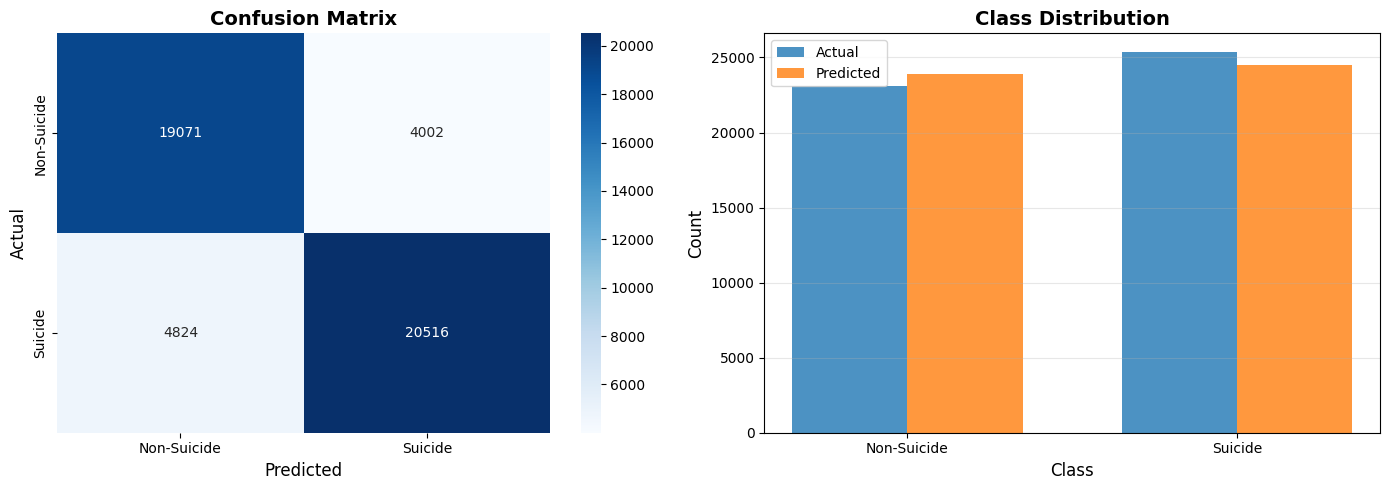

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


def gini_impurity(y):
    if len(y) == 0:
        return 0
    _, counts = np.unique(y, return_counts=True)
    probs = counts / len(y)
    return 1 - np.sum(probs ** 2)

def best_split(X, y, features):
    best_feature = None
    best_thresh = None
    best_gain = 0

    current_impurity = gini_impurity(y)
    n_samples = len(y)

    for feature in features:
        values = X[:, feature]

        thresholds = np.percentile(values, [10, 20, 30, 40, 50, 60, 70, 80, 90])

        for threshold in thresholds:
            left_mask = values <= threshold
            right_mask = ~left_mask

            n_left = np.sum(left_mask)
            n_right = np.sum(right_mask)

            if n_left < 2 or n_right < 2:
                continue

            # Calculate weighted Gini
            left_impurity = gini_impurity(y[left_mask])
            right_impurity = gini_impurity(y[right_mask])

            weighted_impurity = (n_left / n_samples) * left_impurity + (n_right / n_samples) * right_impurity
            gain = current_impurity - weighted_impurity

            if gain > best_gain:
                best_gain = gain
                best_feature = feature
                best_thresh = threshold

    return best_feature, best_thresh, best_gain

class DecisionTree:
    def __init__(self, max_depth=5, min_size=10, n_features=None):
        self.max_depth = max_depth
        self.min_size = min_size
        self.n_features = n_features
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build(X, y, depth=0)

    def _build(self, X, y, depth):
        n_samples, n_features = X.shape

        if (depth >= self.max_depth or
            len(np.unique(y)) == 1 or
            n_samples <= self.min_size):
            return np.bincount(y).argmax()

        n_feat_subset = self.n_features if self.n_features else int(np.sqrt(n_features))
        n_feat_subset = min(n_feat_subset, n_features)
        features = np.random.choice(n_features, n_feat_subset, replace=False)

        feature, threshold, gain = best_split(X, y, features)

        if gain == 0 or feature is None:
            return np.bincount(y).argmax()

        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask

        left = self._build(X[left_mask], y[left_mask], depth + 1)
        right = self._build(X[right_mask], y[right_mask], depth + 1)

        return (feature, threshold, left, right)

    def predict_one(self, x, node=None):
        if node is None:
            node = self.tree

        if not isinstance(node, tuple):
            return node

        feature, threshold, left, right = node

        if x[feature] <= threshold:
            return self.predict_one(x, left)
        else:
            return self.predict_one(x, right)

    def predict(self, X):
        return np.array([self.predict_one(sample) for sample in X])


class RandomForest:
    def __init__(self, n_trees=10, max_depth=7, min_size=10):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_size = min_size
        self.trees = []

    def bootstrap(self, X, y):
        n_samples = len(y)
        idx = np.random.choice(n_samples, n_samples, replace=True)
        return X[idx], y[idx]

    def fit(self, X, y):
        print(f"\n{'='*60}")
        print(f"TRAINING RANDOM FOREST")
        print(f"{'='*60}")
        print(f"Trees: {self.n_trees} | Max depth: {self.max_depth} | Min size: {self.min_size}")
        print(f"Training samples: {X.shape[0]} | Features: {X.shape[1]}")
        print(f"{'='*60}\n")

        self.trees = []
        n_features = int(np.sqrt(X.shape[1]))

        for i in range(self.n_trees):
            print(f"Training tree {i+1}/{self.n_trees}...", end=" ")
            X_sample, y_sample = self.bootstrap(X, y)

            tree = DecisionTree(
                max_depth=self.max_depth,
                min_size=self.min_size,
                n_features=n_features
            )
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
            print("✓")

        print(f"\n{'='*60}")
        print("Training complete!")
        print(f"{'='*60}\n")

    def predict(self, X):
        print(f"Making predictions on {X.shape[0]} samples...")
        tree_preds = np.array([tree.predict(X) for tree in self.trees])

        # Majority vote (vectorized)
        final_pred = np.array([np.bincount(tree_preds[:, i]).argmax() for i in range(X.shape[0])])
        print("Predictions complete!\n")
        return final_pred

print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60)

forest = RandomForest(n_trees=15, max_depth=6, min_size=20)
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print("="*60)
print("MODEL PERFORMANCE")
print("="*60)
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print("="*60)

cm = confusion_matrix(y_test, y_pred)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Non-Suicide', 'Suicide'],
            yticklabels=['Non-Suicide', 'Suicide'])
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)

# Prediction Distribution
pred_counts = pd.Series(y_pred).value_counts().sort_index()
true_counts = pd.Series(y_test).value_counts().sort_index()

x = np.arange(2)
width = 0.35

axes[1].bar(x - width/2, true_counts.values, width, label='Actual', alpha=0.8)
axes[1].bar(x + width/2, pred_counts.values, width, label='Predicted', alpha=0.8)
axes[1].set_xlabel('Class', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(['Non-Suicide', 'Suicide'])
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()
